# Introduction to Cross-Validation - Lab

## Introduction

In this lab, you'll be able to practice your cross-validation skills!


## Objectives

You will be able to:

- Perform cross validation on a model
- Compare and contrast model validation strategies

## Let's Get Started

We included the code to pre-process the Ames Housing dataset below. This is done for the sake of expediency, although it may result in data leakage and therefore overly optimistic model metrics.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

ames = pd.read_csv('ames.csv')

continuous = ['LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']
categoricals = ['BldgType', 'KitchenQual', 'SaleType', 'MSZoning', 'Street', 'Neighborhood']

ames_cont = ames[continuous]

# log features
log_names = [f'{column}_log' for column in ames_cont.columns]

ames_log = np.log(ames_cont)
ames_log.columns = log_names

# normalize (subract mean and divide by std)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

ames_log_norm = ames_log.apply(normalize)

# one hot encode categoricals
ames_ohe = pd.get_dummies(ames[categoricals], prefix=categoricals, drop_first=True)

preprocessed = pd.concat([ames_log_norm, ames_ohe], axis=1)

X = preprocessed.drop('SalePrice_log', axis=1)
y = preprocessed['SalePrice_log']

## Train-Test Split

Perform a train-test split with a test set of 20% and a random state of 4.

In [4]:
# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import  train_test_split



In [5]:
# Split the data into training and test sets (assign 20% to test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [6]:
# Print the shapes of the resulting sets to verify
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1168, 47)
X_test shape: (292, 47)
y_train shape: (1168,)
y_test shape: (292,)


### Fit a Model

Fit a linear regression model on the training set

In [7]:
# Import LinearRegression from sklearn.linear_model
from sklearn.linear_model import  LinearRegression

In [8]:
# Instantiate and fit a linear regression model
neareg = LinearRegression()

neareg.fit(X_train, y_train)

LinearRegression()

### Calculate MSE

Calculate the mean squared error on the test set

In [9]:
# Import mean_squared_error from sklearn.metrics
from sklearn.metrics import mean_squared_error

y_test_pred = neareg.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)


In [10]:
# Calculate MSE on test set
test_mse

0.1523399721070817

## Cross-Validation using Scikit-Learn

Now let's compare that single test MSE to a cross-validated test MSE.

In [11]:
# Import cross_val_score from sklearn.model_selection
from sklearn.model_selection import  cross_val_score

In [12]:
# Find MSE scores for a 5-fold cross-validation

# Perform 5-fold cross-validation
cv_scores = cross_val_score(neareg, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert the scores to positive MSE
cv_mse_scores = -cv_scores

# Calculate the mean and standard deviation of the MSE scores
cv_mean_mse = cv_mse_scores.mean()
cv_std_mse = cv_mse_scores.std()

print(f"Cross-validated MSE: {cv_mean_mse:.4f} (+/- {cv_std_mse:.4f})")
print(f"Single test set MSE: {test_mse:.4f}")

Cross-validated MSE: 0.1770 (+/- 0.0288)
Single test set MSE: 0.1523


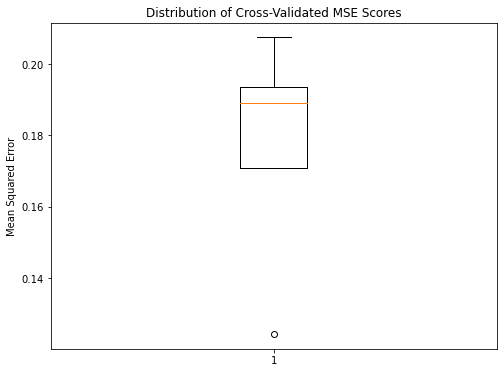

In [13]:
plt.figure(figsize=(8, 6))
plt.boxplot(cv_mse_scores)
plt.title('Distribution of Cross-Validated MSE Scores')
plt.ylabel('Mean Squared Error')
plt.show()

In [14]:
# Get the average MSE score
average_mse = cv_mse_scores.mean()
print(f"Average MSE from cross-validation: {average_mse:.4f}")

Average MSE from cross-validation: 0.1770


Compare and contrast the results. What is the difference between the train-test split and cross-validation results? Do you "trust" one more than the other?

In [15]:
# Your answer here
"""
Train-Test Split Result:
We got a single MSE value from the test set.

Cross-Validation Result:
We got an average MSE across multiple folds, along with a measure of variability (standard deviation).

 If the cross-validation average MSE is close to the single test set MSE, it suggests the model's performance is consistent. 
 If they differ significantly, the cross-validation result is likely more reliable, as it's based on multiple evaluations.
"""

"\nTrain-Test Split Result:\nWe got a single MSE value from the test set.\n\nCross-Validation Result:\nWe got an average MSE across multiple folds, along with a measure of variability (standard deviation).\n\n If the cross-validation average MSE is close to the single test set MSE, it suggests the model's performance is consistent. \n If they differ significantly, the cross-validation result is likely more reliable, as it's based on multiple evaluations.\n"

## Level Up: Let's Build It from Scratch!

### Create a Cross-Validation Function

Write a function `kfolds(data, k)` that splits a dataset into `k` evenly sized pieces. If the full dataset is not divisible by `k`, make the first few folds one larger then later ones.

For example, if you had this dataset:

In [16]:
example_data = pd.DataFrame({
    "color": ["red", "orange", "yellow", "green", "blue", "indigo", "violet"]
})
example_data

,color
0,red
1,orange
2,yellow
3,green
4,blue
5,indigo
6,violet


`kfolds(example_data, 3)` should return:

* a dataframe with `red`, `orange`, `yellow`
* a dataframe with `green`, `blue`
* a dataframe with `indigo`, `violet`

Because the example dataframe has 7 records, which is not evenly divisible by 3, so the "leftover" 1 record extends the length of the first dataframe.

In [17]:
def kfolds(data, k):
    folds = []
    
    # Your code here
    folds = []
    n = len(data)
    base_size = n // k
    extras = n % k
    
    start = 0
    for i in range(k):
        end = start + base_size + (1 if i < extras else 0)
        folds.append(data.iloc[start:end].reset_index(drop=True))
        start = end
        
    return folds

In [18]:
results = kfolds(example_data, 3)
for result in results:
    print(result, "\n")

    color
0     red
1  orange
2  yellow 

   color
0  green
1   blue 

    color
0  indigo
1  violet 



### Apply Your Function to the Ames Housing Data

Get folds for both `X` and `y`.

In [20]:
import pandas as pd

# combine x and y into a single dataframe
ames_data = pd.concat([X, y], axis=1)

# Apply kfolds() to ames_data with 5 folds
k = 5
folds = kfolds(ames_data, k)


In [21]:
#separate X and y for each fold
X_folds = []
y_folds = []

for fold in folds:
    X_folds.append(fold.drop('SalePrice_log', axis=1))
    y_folds.append(fold['SalePrice_log'])

In [23]:
# print out the shapes of each fold to verify
for i in range(k):
    print(f'Fold {i+1}:')
    print(f'X shape: {X_folds[i].shape}, y shape: {y_folds[i].shape}')
    print()

Fold 1:
X shape: (292, 47), y shape: (292,)

Fold 2:
X shape: (292, 47), y shape: (292,)

Fold 3:
X shape: (292, 47), y shape: (292,)

Fold 4:
X shape: (292, 47), y shape: (292,)

Fold 5:
X shape: (292, 47), y shape: (292,)



### Perform a Linear Regression for Each Fold and Calculate the Test Error

Remember that for each fold you will need to concatenate all but one of the folds to represent the training data, while the one remaining fold represents the test data.

In [25]:
# Replace None with appropriate code
test_errs = []
k = 5

for n in range(k):
    # Split into train and test for the fold
    X_train = pd.concat([X_folds[i] for i in range(k) if i != n])
    X_test = X_folds[n]
    y_train = pd.concat([y_folds[i] for i in range(k) if i != n])
    y_test = y_folds[n]
    
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Evaluate test errors
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    test_errs.append(mse)

print("Test errors for each fold:")
for i, err in enumerate(test_errs):
    print(f'Fold {i+1}: {err:4f}')

print(f'\nAverage test error: {sum(test_errs)/len(test_errs):4f}')

Test errors for each fold:
Fold 1: 0.124315
Fold 2: 0.193501
Fold 3: 0.189105
Fold 4: 0.170793
Fold 5: 0.207427

Average test error: 0.177028


If your code was written correctly, these should be the same errors as scikit-learn produced with `cross_val_score` (within rounding error). Test this out below:

In [26]:
# Compare your results with sklearn results


# Our manual implementation results
print("Manual implementation results:")
print(f"Average test error: {sum(test_errs)/len(test_errs):.4f}")
print(f"Individual fold errors: {[f'{err:.4f}' for err in test_errs]}")

# Scikit-learn implementation
model = LinearRegression()
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_errors = -cv_scores  # Convert to positive MSE

print("\nScikit-learn cross_val_score results:")
print(f"Average test error: {cv_errors.mean():.4f}")
print(f"Individual fold errors: {[f'{err:.4f}' for err in cv_errors]}")

# Compare the results
print("\nDifference in average error:")
print(f"{abs(sum(test_errs)/len(test_errs) - cv_errors.mean()):.6f}")

print("\nDifferences in individual fold errors:")
for manual, sklearn in zip(test_errs, cv_errors):
    print(f"{abs(manual - sklearn):.6f}")

Manual implementation results:
Average test error: 0.1770
Individual fold errors: ['0.1243', '0.1935', '0.1891', '0.1708', '0.2074']

Scikit-learn cross_val_score results:
Average test error: 0.1770
Individual fold errors: ['0.1243', '0.1935', '0.1891', '0.1708', '0.2074']

Difference in average error:
0.000000

Differences in individual fold errors:
0.000000
0.000000
0.000000
0.000000
0.000000


This was a bit of work! Hopefully you have a clearer understanding of the underlying logic for cross-validation if you attempted this exercise.

##  Summary 

Congratulations! You are now familiar with cross-validation and know how to use `cross_val_score()`. Remember that the results obtained from cross-validation are more robust than train-test split.